In [1]:
from matplotlib import pyplot as plt
from matplotlib import patches
import rasterio
from rasterio.plot import show as rastershow

import numpy as np
import pandas as pd
import os
import glob

import geopandas as gpd

from shapely.geometry import Point, Polygon

## Quick check for processed data

After running the preprocessing script, run this notebook for a quick sanity check of the processed outputs.

All data is located in `/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/`.

These are all the labeled tiles:

In [2]:
shapes = np.sort(glob.glob('/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_*.shp'))

In [3]:
shapes

array(['/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_0_0.shp',
       '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_0_1.shp',
       '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_1_0.shp',
       '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_1_1.shp',
       '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_2_0.shp'],
      dtype='<U86')

In [4]:
print(f'Number of available shape files for tiles: {len(shapes)}')

Number of available shape files for tiles: 5


We process one of the label files and check the coordinate reference system (CRS). The label files need to be cast to the same CRS as the raster images. They are given in `EPSG:4326` and are now cast to `EPSG:25832`.

In [5]:
polygons = gpd.read_file('/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_0_1.shp')
polygons.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
rastertif = rasterio.open(os.path.join('/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/', 'tiles', 'tile_0_1.tif'))
rastertif.crs

CRS.from_epsg(25832)

In [7]:
polygons = polygons.set_crs(epsg=4326) # needed this explicitly
polygons = polygons.to_crs(epsg=25832)
polygons.crs

<Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.01, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

For preprocessing and plots, we need all polygons combined in one file. This is created here and saved in `/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/all_labels.shp`.

In [8]:
all_polygons = pd.concat([gpd.read_file(shape).set_crs(epsg=4326).to_crs(epsg=25832).assign(tile=shape) for shape in shapes])
all_polygons.drop(columns='tile').to_file('/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/all_labels.shp')

In [9]:
all_polygons.head()

,id,class,geometry,tile
0,0,0,"POLYGON ((704006.919 5709953.981, 704007.922 5...",/work/ka1176/shared_data/2024-ufz-deeptree/pol...
1,4,0,"POLYGON ((704086.24 5709960.868, 704085.993 57...",/work/ka1176/shared_data/2024-ufz-deeptree/pol...
2,5,0,"POLYGON ((704094.602 5709963.4, 704096.35 5709...",/work/ka1176/shared_data/2024-ufz-deeptree/pol...
3,6,0,"POLYGON ((704029.35 5709936.794, 704030.126 57...",/work/ka1176/shared_data/2024-ufz-deeptree/pol...
4,7,0,"POLYGON ((704032.327 5709930.838, 704032.781 5...",/work/ka1176/shared_data/2024-ufz-deeptree/pol...


### Check the preprocessed raster files

We are starting with 
- tiles
- labels

In preprocessing, we created
- masks
- outlines
- distance transforms

In [10]:
tiles = [shape.replace('labels/', 'tiles/').replace('label_', '').replace('.shp', '.tif') for shape in shapes]
masks = [shape.replace('labels/', 'masks/').replace('label_tile_', 'mask_').replace('.shp', '.tif') for shape in shapes]
outlines = [shape.replace('labels/', 'outlines/').replace('label_tile_', 'outline_').replace('.shp', '.tif') for shape in shapes]
distance_transforms = [shape.replace('labels/', 'dist_trafo/').replace('label_tile_', 'dist_trafo_').replace('.shp', '.tif') for shape in shapes]

In [11]:
all_rastertifs = [rasterio.open(tile) for tile in tiles]
all_bounds = [rastertif.bounds for rastertif in all_rastertifs]
all_extents = [(b.left, b.bottom, b.right, b.top) for b in all_bounds]

#### Sanity check for masks

The following plot shows all the labeled tiles (RGB images) and the labeled polygons (cyan). The masks are overlayed in blue.

The cyan outlines should match the masks.

<Axes: >

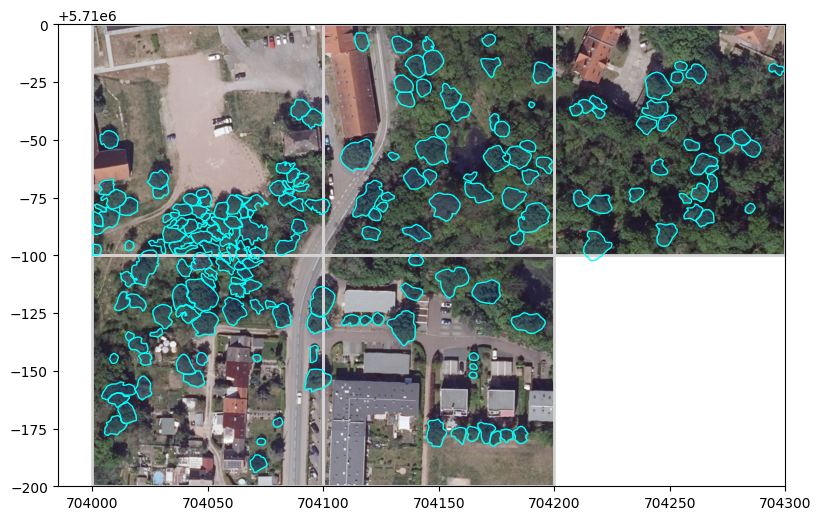

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# add original tiles
for rastertif in all_rastertifs:
    rastershow(rastertif, ax=ax)

# check if mask is correct
for mask in masks:
    rastershow(rasterio.open(mask), ax=ax, alpha=0.35, cmap='Blues_r', with_bounds=True)

# add bounding boxes to display
for extent in all_extents:
    rc = patches.Rectangle((extent[0], extent[1]), extent[2]-extent[0], extent[3]-extent[1],
                           lw=2, fc='none', ec='lightgray',
                          )
    ax.add_patch(rc)

# all labeled polygons
all_polygons.plot(column='tile', ax=ax, facecolor='none', edgecolor='cyan')

#### Sanity check for outlines

The outlines are a bit hard to see in the overlay, so we perform the sanity check by comparing them against the masks. The outlines (red) should match the polygons (blue).

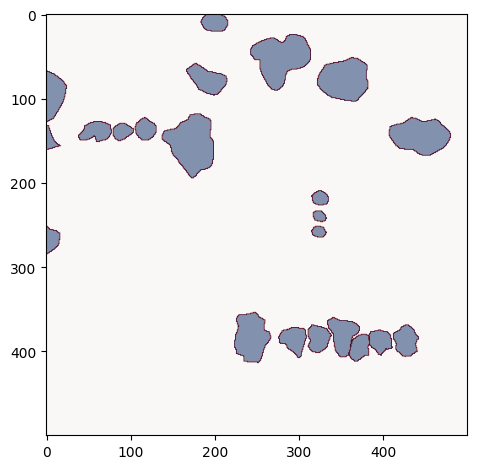

In [13]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

k = 3 # tile index

mask = rasterio.open(masks[k]).read()
ax.imshow(mask.squeeze(), cmap='Blues')

outline = rasterio.open(outlines[k]).read()
ax.imshow(outline.squeeze(), cmap='Reds', alpha=0.5)

fig.tight_layout()
plt.show()

#### Sanity check for distance transforms

The distance transforms denotes the distance of a point within the polygon to its boundary. Again, the shapes should match. The heatmap colors inside the polygons should reflect the distance to the boundary.

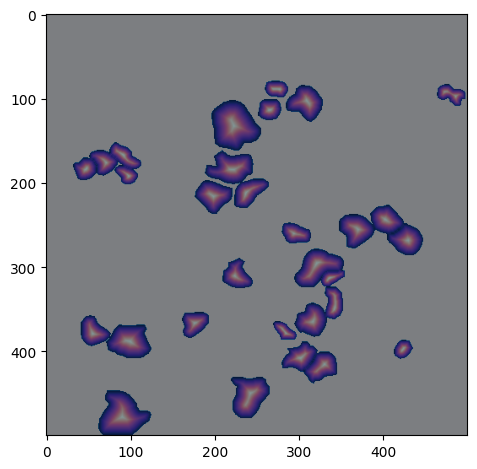

In [14]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

k = 4 # tile index

mask = rasterio.open(masks[k]).read()
ax.imshow(mask.squeeze(), cmap='Blues')

dist_trafo = rasterio.open(distance_transforms[k]).read()

ax.imshow(dist_trafo.squeeze(), cmap='magma', alpha=0.5)

fig.tight_layout()
plt.show()